# Natural Language Processing and Clustering - Wild Swimming

In this project I will use natural language processing (NLP) and unsupervised machine learning to analyse descriptions of wild swimming locations.   

I am a big fan of wild swimming and this website http://www.wildswimming.co.uk/ is a good resource for finding new spots. They list around ~200 wild swiiming locations and have a small text description about each one. I have already scraped the text description data from the website (see *Data Acquisition via Web Scraping.ipynb*) and in this notebook I will:  
1. Use NLP techniques (bag of words, stemming, TF-IDF etc.) to convert the text descriptions into vectors.
2. Use the cosine similarity to calculate which locations have similar descriptions - this can be used as a reccomendation model based on previous likes. 
3. Build a search engine for the wild swimming collection. 
4. Use clustering methods to see if there is any structure within the wild swimming collection. 

#### As a running example:   
One of the best wild swimming spots I've been too is Holne Pool on the River Dart. The wild swimming website has a description here http://www.wildswimming.co.uk/map/holne-pool/ .
<img src="holne_pool.jpg" alt="drawing" width="400"/>

First I will import all the dependencies:

In [21]:
# basics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import string

# nlp
import nltk    
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

# distance measurement
from sklearn.metrics.pairwise import cosine_similarity

# clustering
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier, plot_tree  # to understand how the clusters are split

# visualisation
from yellowbrick.text import TSNEVisualizer

## Natural language processing

In NLP lingo: the collection of wild swimming descriptions is called the *corpus* and each description is called a *document*. To be clear each wild swimming location has one text description.  

In order to feed the text data into (most) machine learning algorithms we must first convert it into a vector of numbers. In this project I am using the bag of words approach where each document is considered a collection of words with no regards for the order they appear in. We weight the importance of different words by how often they appear in the document and how often they appear in the corpus as whole. This is the term frequency - inverse document frequency weighting. 

Let's import the data:

In [2]:
df = pd.read_csv("corpus.csv")
df.head()

,Location Name,Description
0,Cornish Tipi Holidays,"A luscious, chalk-green, spring-fed quarry lak..."
1,Colliford Lake and Dozmary,"A huge moorland lake, the highest and largest ..."
2,St Nectan’s Kieve,"A tall, slender Waterfall or Gorge at the head..."
3,Spitchwick Common,"Peaty water, clean from the mountain, this is..."
4,Respryn Bridge,Wooded National Trust estate riverside walk. S...


Let's look at the entry for Holne Pool

In [3]:
hp_index = df.index[df['Location Name'] == ' Holne Pool '][0]
print('Holne Pool is at index', hp_index)
print(df.loc[hp_index, :].values)

Holne Pool is at index 6
[' Holne Pool '
 'Small Waterfall or Gorge with sunbathing rock and large pool in secluded Holne Woods, close to Holne and its pub.']


### Tokenization

The first step is to turn each desription into a list of its words (also called tokens). We also take this opportunity to set all the text to lower case. 

In [4]:
example_text = df.loc[hp_index, 'Description']
print('The text:', example_text,'\n')
example_tokens = word_tokenize(example_text.lower())
print('The tokens:', example_tokens)

The text: Small Waterfall or Gorge with sunbathing rock and large pool in secluded Holne Woods, close to Holne and its pub. 

The tokens: ['small', 'waterfall', 'or', 'gorge', 'with', 'sunbathing', 'rock', 'and', 'large', 'pool', 'in', 'secluded', 'holne', 'woods', ',', 'close', 'to', 'holne', 'and', 'its', 'pub', '.']


### Remove stopwords and punctuation

Next we remove all the *stopwords* from the text. These are words like 'and', 'the', 'me'   that don't convey much meaning. We also remove the punctuation. 

In [5]:
stopwords = nltk.corpus.stopwords.words('english')   # nltk has a list of stopwords
print('Some stopwords are:', stopwords[:10], '\n')

# Remove stopwords
example_tokens = [t for t in example_tokens if t not in stopwords]
print('The tokens with stopwords removed:', example_tokens, '\n')

# Remove punctuation
example_tokens = [t for t in example_tokens if t not in string.punctuation]   # string has a list of punctuation
print('The tokens with punctuation removed:', example_tokens)

Some stopwords are: ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"] 

The tokens with stopwords removed: ['small', 'waterfall', 'gorge', 'sunbathing', 'rock', 'large', 'pool', 'secluded', 'holne', 'woods', ',', 'close', 'holne', 'pub', '.'] 

The tokens with punctuation removed: ['small', 'waterfall', 'gorge', 'sunbathing', 'rock', 'large', 'pool', 'secluded', 'holne', 'woods', 'close', 'holne', 'pub']


### Stemming

Next we stem the words. This is to reduce the amount of tokens and so that words like 'swim', 'swimming', 'swims' which have essentially the same meaning are represented by the same token - in this case 'swim'

In [6]:
# Stem words
example_tokens = [PorterStemmer().stem(t) for t in example_tokens]   # string has a list of punctuation
print('The tokens after stemming:', example_tokens)

The tokens after stemming: ['small', 'waterfal', 'gorg', 'sunbath', 'rock', 'larg', 'pool', 'seclud', 'holn', 'wood', 'close', 'holn', 'pub']


Notice the effect on the word 'sunbathing' which becomes 'sunbath'. Some of the tokens now look a bit weird but they can now represent a set of words. Another option is to *lemmatize* the tokens instead. This is a similar but slightly different process and here I opt for the simpler stemming.

### TF-IDF

Now we can convert the list of tokens into a vector of numbers. This requires training on the entire corpus as we need to know all the possible tokens. If there are N different tokens in the corpus each document is turned into a N-dimensional vector. The element $x_n$ corresponding to the $n$-th token is given by

$$
x_n = \text{Term Frequency} \times \text{Inverse Document Frequency} 
$$

Where Term Frequency is the amount of times the token appears in the document divided by the total number of tokens in the document. And Inverse Document Frequency is the log of the number of total documents divided by the number of documents containing that term. 

TF-IDF ensures that length of each document doesn't effect the representation and that very common words have reduced importance. 

I will use sklearn's TfidfVectorizer:

In [7]:
# a list of all the descriptions
corpus = df.loc[:,'Description'].values

In [8]:
# define a custom tokenization step
# this does the same as the example run thorugh above
def tokenizer(text):
    tokens = word_tokenize(text.lower())                         # tokenize
    tokens = [t for t in tokens if t not in string.punctuation]  # remove punctuation
    tokens = [t for t in tokens if t not in stopwords]           # remove stopwords
    tokens = [PorterStemmer().stem(t) for t in tokens]                    # stem
    return tokens

# define vectorizer object
vectorizer = TfidfVectorizer(tokenizer=tokenizer, ngram_range = (1,1), min_df = 0.02, max_df = 0.5)
# fit it on the corpus then trainsform the corpus to tfidf_matrix
tfidf_matrix = vectorizer.fit_transform(corpus)

print('The tfidf_matrix has shape:',tfidf_matrix.shape)

The tfidf_matrix has shape: (199, 280)


The rows of the TF-IDF matrix are the vector representations of each document. The vectors are high dimensional but we can see which features are most important for each document. E.g. for Holne Pool

In [9]:
terms = vectorizer.get_feature_names()
hp_row = np.squeeze(tfidf_matrix[hp_index].toarray())
topn_ids = np.argsort(hp_row)[::-1][:5]
top_feats = [(terms[i], hp_row[i]) for i in topn_ids]
topfeats_df = pd.DataFrame(top_feats)
topfeats_df.columns = ['feature', 'tfidf']
topfeats_df

,feature,tfidf
0,close,0.400982
1,seclud,0.400982
2,pub,0.376189
3,wood,0.325153
4,larg,0.294466


## Cosine similarity

Now the documents are in a vector form we can ask: which documents are *similar*? Similar here can could be defined by the Euclidean distance between two document vectors... but it turns out for text a better metric is the *cosine similarity*.

$$
\text{Cosine Similarity} = \frac{\textbf{A}\cdot\textbf{B}}{|\textbf{A}||\textbf{B}|}
$$

We can define a distance matrix containing the cosine similarity between all the documents in the corpus:

In [10]:
distance_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix, dense_output=True)
# All diag values = 1 so we set to zero so that we can search for largest similaries
distance_matrix = distance_matrix - np.diag(np.diag(distance_matrix))   

Then lets ask: Which swimming locations are most similar to Holne Pool? 

In [11]:
hp_similarity_order = np.argsort(-distance_matrix[hp_index,:]) # minus sign for descending sort order.
for n in range(3):
    match_index = hp_similarity_order[n]
    print(n+1, '. Cosine Similarity:', distance_matrix[hp_index, match_index])
    print(df.loc[match_index, :].values, '\n')
    
print('As a reminder:')
print(df.loc[hp_index, :].values)

1 . Cosine Similarity: 0.511378632002939
[' Mel Tor Pools ' 'Small Waterfall or Gorge pool'] 

2 . Cosine Similarity: 0.373966658906794
[' Gill Force, Eskdale '
 'A small rocky gorge and pool on the Esk, close to the village of boot with its campsite and pub. Near the little riverside church. Shady. Deep section with rocks to jump from.'] 

3 . Cosine Similarity: 0.36395127767366664
[' Cullever Steps '
 'Small plunge pool in narrow rocky valley below Scarey Tor. Some grass for picnics and large rocks for sunbathing. Small Waterfall or Gorge. 1.5m deep. 15m long.'] 

As a reminder:
[' Holne Pool '
 'Small Waterfall or Gorge with sunbathing rock and large pool in secluded Holne Woods, close to Holne and its pub.']


These show a good similariy to Holne Pool. The key words linking the locations seem to be Small, Waterfall, Pool, Deep. 

In fact, it turns out the Mel Tor Pools location is only a few hundred meters up the same river from Holne Pool! The descriptions hold latent information about their location due to the language used to describe them. E.g. you only find Lochs in Scotland!

## A wild swimming search engine

Instead of working out the most similar documents to an existing document we can find the similarity of all documents in the corpus to a user given search query. This is how search engines work. I can define the search engine as a function:

In [12]:
# define as function.
def wild_swim_search(query):
    # transform search query into vector using the TFIDF vectoriser trained on the corpus
    query_vec = vectorizer.transform([query])  
    
    # calculate cosine distance to all documents in the corpus
    search_distance_matrix = cosine_similarity(query_vec, tfidf_matrix, dense_output=True)[0]
    
    # sort the documents by cosine distance from the search query
    search_results = np.argsort(-search_distance_matrix)     # minus sign so that we get most similar first. (i.e. argsort descending)
    
    # print 5 closest documents
    for n in range(5):
        result_id = search_results[n]
        print(df.loc[result_id, :].values)
        print('Cosine similarity of', search_distance_matrix[result_id])
        print()

And here are some examples:

In [13]:
wild_swim_search('Big lake with sandy beach')

[' Frensham Great Pond '
 'Huge sandy lake with small buoyed-off swimming area shelving to 1.5m deep and 50m wide. Forest and open heathland. Parking, cafﾎ and small museum, Popular with young families.']
Cosine similarity of 0.3080730211730229

[' Coastal – Tanners Lane, Lymington '
 'Great remote location for pool swimming at mid tide. Can park right on beach (but watch the tide!) with long stretch of beach going east. Tucked behind in the woods is a massive lake and although very enticing for swimming, we found the pond weeds a bit hard to contend with!']
Cosine similarity of 0.2914382239661643

[' Dulsie Bridge '
 'Stunning gorge with rapids above and deep pools, Waterfall or Gorge and sandy cove below.']
Cosine similarity of 0.29060072508931595

[' Backney Common '
 'Ancient but little known common in tight loop of Wye providing large shingle and sandy beach shelving to large deep pool. Undisputed access. Large swan population, with droppings.']
Cosine similarity of 0.282307979750

In [14]:
wild_swim_search('Quiet river')

[' Thames dip, near Grafton Lock '
 'This is a quiet stretch of the Thames between Lechlade and Radcot.']
Cosine similarity of 0.7470697088859741

[' Lamas, River Bure '
 'A quiet, rural idyllic stretch of the Bure river, flowing past gardens, fields and a church. Deep and clear running. Banks can be rather wet and marshy.']
Cosine similarity of 0.4107379109035667

[' River Teme, Leintwardine '
 'Nice quiet spot in the summer at the joining of the River Teme and River Clun for a swim or a paddle. The River Teme lazily winds it’s way towards the site through a lovely green meadow and is mainly warm, clear and shallow. The River Clun runs towards the site through a confluence and (I’m assuming) was used as the old mill stream.']
Cosine similarity of 0.3543751413603663

[' Dedham Vale '
 'A beautiful open historic vale, site of Flatford Mill, where people row on boats and occasionally swim. Fen Bridge is a quiet spot with 2m deep river pools and shelving access. Some weeds to watch for. G

In [15]:
wild_swim_search('Shallow and safe for children')

[' Shilley Pool '
 'Small, dammed plunge pool in brook at edge of moor. Shallow (1m) but set beneath flat rock rapids with nice picnicking grass alongside. Paddling for children. Sheltered and balmy in summer. Park in South Zeal.']
Cosine similarity of 0.2717517983908033

[' Chilbolton Cow Common '
 'Ancient rural common bounded by two arms of the Test. Two shallow pools by footbridge, white gravel, very clear and clean. Popular with children. Cold, about 15ﾼC all year round.']
Cosine similarity of 0.2666077775809246

[' Cuckmere Meanders '
 'Wide, shallow, moderately warm oxbow lakes cut off from the main Cuckmere stream. Grass banks and chalky beds. Non tidal and no current. Safe and deep enough for swimming in some places. Stunning setting with option of sea swimming too.']
Cosine similarity of 0.24856660007698692

[' Hope House Open Water Swim '
 'Hope House Children’s Hospices are organising their first sponsored open water swim to help raise funds for the hospices. The swim will 

This works very well! 

## Clustering

Finally, I want to see in there is any structure in the vector space of wild swimming locations. For these I can use clustering - an unsupervised machine learning technique. First lets visualise the space of wild swim descipritions using TSNE to reduce the high dimensional vector space to just 2D. 

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


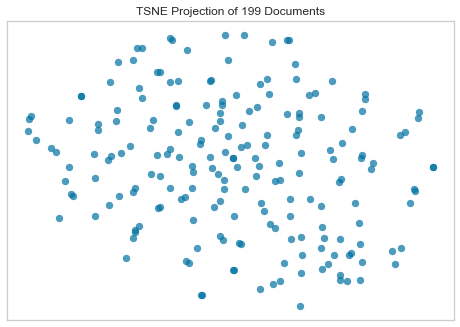

In [16]:
tsne = TSNEVisualizer()
tsne.fit(tfidf_matrix)
tsne.show()

Here we only see one large cluster. This is to be expected as all of the desciptions are about the same thing: wild swimming. All of the documents are quite similar to each other. However, let's see if a clustering algorithm picks out any underlying structure:

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


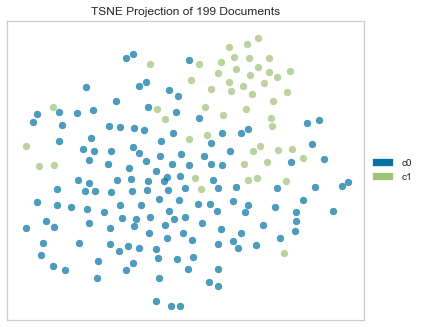

In [17]:
# K-means algorithm 

# Fit 
kmeans = KMeans(n_clusters=2).fit(tfidf_matrix)

#visualise
tsne_km = TSNEVisualizer()
tsne_km.fit(tfidf_matrix, ["c{}".format(c) for c in kmeans.labels_])
tsne_km.show()

The clustering algorithm finds a small cluster in the data: We can inspect the elements of each class to see identify what defines them.

In [18]:
# get class predicitons from kmeans
cluster_labels = kmeans.predict(tfidf_matrix)  # these are 0 or 1 depending on assigned class

# number of instances to observe
N_instances = 5

# first class
class_0_indices = np.where(cluster_labels == 0)[0]
print('The first cluster contains: \n')
for index in class_0_indices[:N_instances]:
    print(df.loc[index,:].values)

# second class
class_1_indices = np.where(cluster_labels == 1)[0]
print('\n The second cluster contains: \n')
for index in class_1_indices[:N_instances]:
    print(df.loc[index,:].values)

The first cluster contains: 

[' Cornish Tipi Holidays '
 'A luscious, chalk-green, spring-fed quarry lake on private land, part of Cornish Tipi Holidays. Wooded cliffs and banks. Very deep and 200m long. Canoes, islands, fishing, landing bay. You need to be staying to swim: tipis from ﾣ275 for a mini break.']
[' Colliford Lake and Dozmary '
 'A huge moorland lake, the highest and largest in Cornwall. Open access on the west side with chalky, shelving beaches. Dippers, wagtails and sand martins. No trees.']
[' Spitchwick Common '
 ' Peaty water, clean from the mountain, this is the most popular and accessible Dart swimming location, especially in summer. Also known as Deeper Marsh, it has been a bathing place for generations. Grassy flats lead to rocky river shore, deeper on far side with high cliff behind.']
[' Respryn Bridge '
 'Wooded National Trust estate riverside walk. Some sections 1.5’2m deep. Swim against the current. Wooden bankside deckings (for fishing). Beachy shingle area

So with a visual inspection we can see that the clustering algorithm has split the wild swimming locations into those that have waterfalls and those that don't!

Let's train a simple decision tree to see if this is the case. (We now use the set clusters as a label so this becomes a supervised learning problem.)

In [40]:
dtc = DecisionTreeClassifier(criterion='entropy', max_depth = 2)   # want a shallow tree to see most important features
dtc.fit(tfidf_matrix, cluster_labels);  

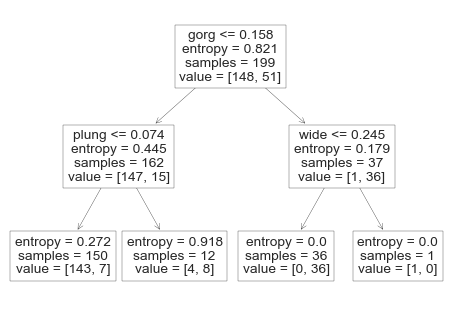

In [41]:
plot_tree(dtc, feature_names=terms);   # to visualise the tree

So actually the presence of the terms gorge and plunge are more important that the term waterfall! Broadly - if the description contains the words gorge or plunge it is one cluster and the decription is in the other cluster if not. 

## Conclusion

In this notebook I have used NLP to analyse a corpus of wild swimming text description. I have used the bag-of-words approach to vectorise each text description and analysed the cosine similarity between documents. I built a search engine for the wild swimming corpus and used clustering to find some structure in the corpus.

I experimented with other clustering algorithms (hierarchical and gaussian mixtures) and with fine tuning the hyperparameters but really this kmeans clustering gave the most sensible results. I think trying to find more clusters is hard as the texts are so similar.

More advanced NLP techniques for this dataset could involve redoing the bag of words approach but with n-grams higher than n=1. I.e. tokenising all word pairs (n=2). Or using a word2vec embedding. 